In [24]:
import numpy as np  # linear algebra operations
import pandas as pd  # data processing, CSV file input/output (e.g., pd.read_csv)

In [25]:
import os
from glob import glob
import pandas as pd

base_dir = 'Dataset'
class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

image_paths = []
labels = []

for idx, cls in enumerate(class_names):
    class_folder = os.path.join(base_dir, cls)
    # Collect jpg and jpeg files together
    files = []
    for ext in ('*.jpg', '*.jpeg'):
        files.extend(glob(os.path.join(class_folder, ext)))
    image_paths.extend(files)
    labels.extend([idx] * len(files))

# Create a DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

print(df.head())               # Show first 5 rows
print(df['label'].value_counts())  # Class distribution


                        image_path  label
0      Dataset\cataract\0_left.jpg      0
1    Dataset\cataract\103_left.jpg      0
2  Dataset\cataract\1062_right.jpg      0
3   Dataset\cataract\1083_left.jpg      0
4  Dataset\cataract\1084_right.jpg      0
label
1    1098
3    1074
0     938
2     906
Name: count, dtype: int64


In [26]:
from PIL import Image
import numpy as np

SIZE = 32

def load_and_preprocess_image(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((SIZE, SIZE))
    img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img

# Load and preprocess all images
X = np.array([load_and_preprocess_image(p) for p in df['image_path']])
y = df['label'].values

print(X.shape)  # (total_number_of_images, 32, 32, 3)
print(y[:10])   # First 10 labels


(4016, 32, 32, 3)
[0 0 0 0 0 0 0 0 0 0]


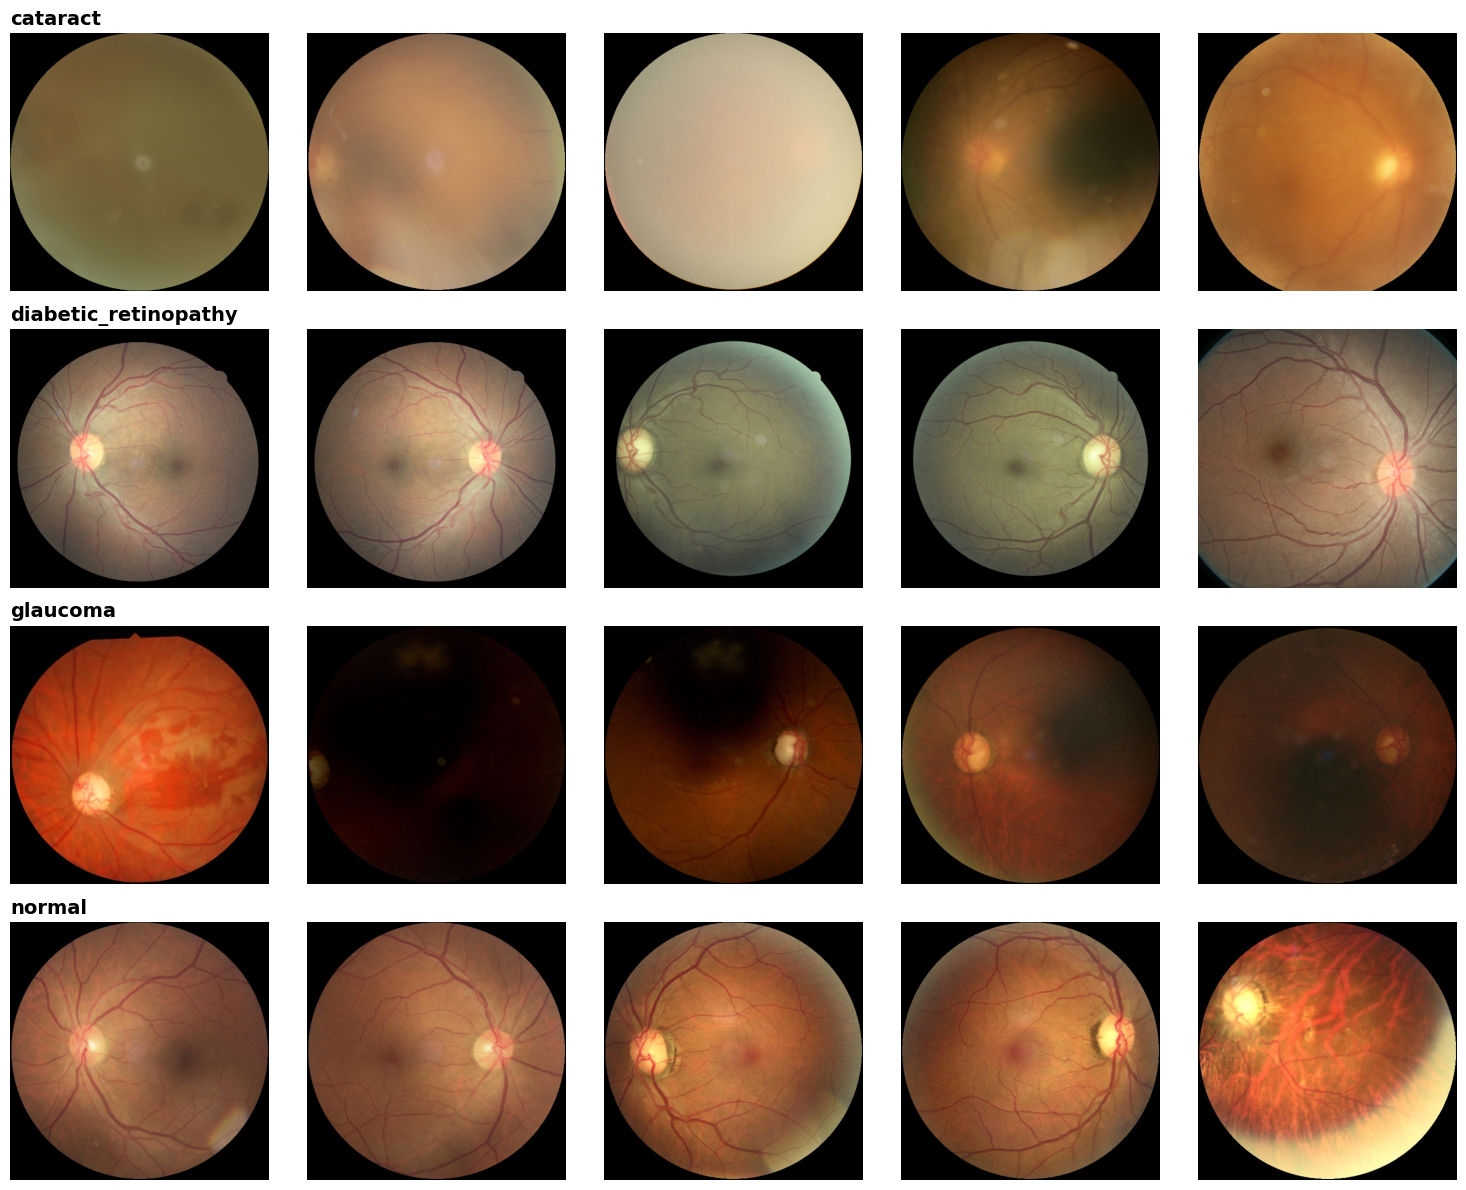

In [27]:
import matplotlib.pyplot as plt
from PIL import Image

def show_original_images_by_class(df, class_names, samples_per_class=5):
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))

    for class_index, class_name in enumerate(class_names):
        # Get the first `samples_per_class` image paths belonging to the current class
        class_df = df[df['label'] == class_index].head(samples_per_class)
        
        for i, image_path in enumerate(class_df['image_path']):
            img = Image.open(image_path).convert('RGB')
            ax = axes[class_index, i] if num_classes > 1 else axes[i]
            ax.imshow(img)
            ax.axis('off')

            # Set the class name as the title on the first image of each row
            if i == 0:
                ax.set_title(class_name, fontsize=14, fontweight='bold', loc='left')

    plt.tight_layout()
    plt.show()

# Run the function
show_original_images_by_class(df, class_names)


In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(x_train.shape, x_test.shape)
print(len(y_train), len(y_test))

(3212, 32, 32, 3) (804, 32, 32, 3)
3212 804


In [29]:
from tensorflow.keras.utils import to_categorical

num_classes = len(class_names)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(y_train_cat.shape, y_test_cat.shape)

(3212, 4) (804, 4)


In [30]:
import autokeras as ak

# Create an ImageClassifier object
clf = ak.ImageClassifier(
    overwrite=True,    # Clear previous models
    max_trials=1,      # Number of models to try (can be increased)
    seed=42
)

# Train the model
clf.fit(x_train, y_train_cat, epochs=100, validation_data=(x_test, y_test_cat))

Trial 1 Complete [00h 00m 59s]
val_loss: 0.43029674887657166

Best val_loss So Far: 0.43029674887657166
Total elapsed time: 00h 00m 59s
Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4970 - loss: 1.1446 - val_accuracy: 0.6816 - val_loss: 0.7857
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6566 - loss: 0.7768 - val_accuracy: 0.7338 - val_loss: 0.6631
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7309 - loss: 0.6465 - val_accuracy: 0.7662 - val_loss: 0.5906
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7458 - loss: 0.6048 - val_accuracy: 0.7674 - val_loss: 0.5788
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7638 - loss: 0.5537 - val_accuracy: 0.7799 - val_loss: 0.5651
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7744 - loss: 0.5273 - val_accuracy: 0.7823 - val_loss: 0.5527
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7814 - loss: 0.5

In [31]:
model = clf.export_model()
loss, accuracy = model.evaluate(x_test, y_test_cat)
print(f"Test accuracy: {accuracy:.4f}")


c:\Users\Sonam Sonam\Desktop\Personal_DL\venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8352 - loss: 0.5670
Test accuracy: 0.8545


In [32]:
# model.save('Model_Handwriten.h5')
model.save('saved_model/best_pick_model.keras')

In [33]:
model = clf.export_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32 (CastToFloat32) │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        50,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,579 (271.80 KB)

 Trainable params: 69,572 (271.77 KB)

 Non-trainable params: 7 (32.00 B)

In [34]:
model = clf.export_model()
model.summary()

from tensorflow.keras.models import Model

# A Flatten or global pooling layer is usually suitable for feature extraction
feature_layer = model.get_layer(index=-2).output  # Typically the layer before the final dense layer

feature_extractor = Model(inputs=model.input, outputs=feature_layer)

X_train_features = feature_extractor.predict(x_train)
X_test_features = feature_extractor.predict(x_test)

print("Feature matrix dimensions:", X_train_features.shape)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32 (CastToFloat32) │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        50,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,579 (271.80 KB)

 Trainable params: 69,572 (271.77 KB)

 Non-trainable params: 7 (32.00 B)

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Feature matrix dimensions: (3212, 4)


In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_train_int = np.argmax(y_train_cat, axis=1)
y_test_int = np.argmax(y_test_cat, axis=1)


models = {
    "Neural Network": MLPClassifier(random_state=42),
    "k-NN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(probability=True,random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_features, y_train_int)
    preds = model.predict(X_test_features)
    acc = accuracy_score(y_test_int, preds)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"{name} Classification Report:\n{classification_report(y_test_int, preds)}\n")

Neural Network Accuracy: 0.8582
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       188
           1       1.00      0.98      0.99       220
           2       0.76      0.77      0.77       181
           3       0.80      0.78      0.79       215

    accuracy                           0.86       804
   macro avg       0.85      0.86      0.85       804
weighted avg       0.86      0.86      0.86       804


k-NN Accuracy: 0.8532
k-NN Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       188
           1       0.99      0.99      0.99       220
           2       0.75      0.75      0.75       181
           3       0.78      0.78      0.78       215

    accuracy                           0.85       804
   macro avg       0.85      0.85      0.85       804
weighted avg       0.85      0.85      0.85       804


Logistic

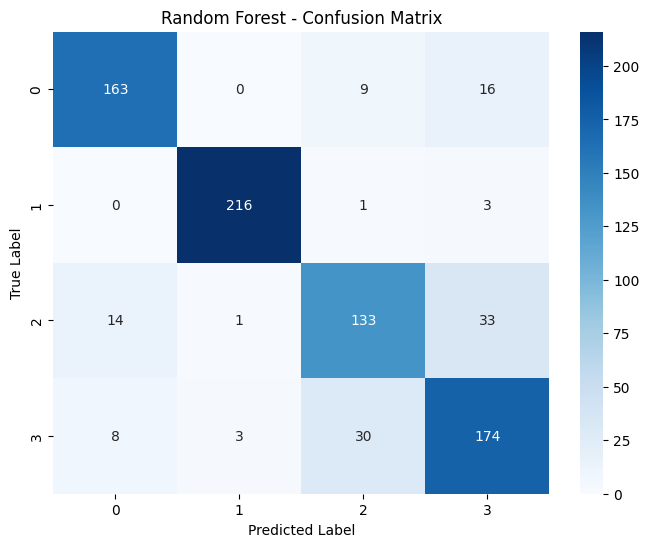

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test_int, models["Random Forest"].predict(X_test_features))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test_int), 
            yticklabels=np.unique(y_test_int))

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest - Confusion Matrix')
plt.show()


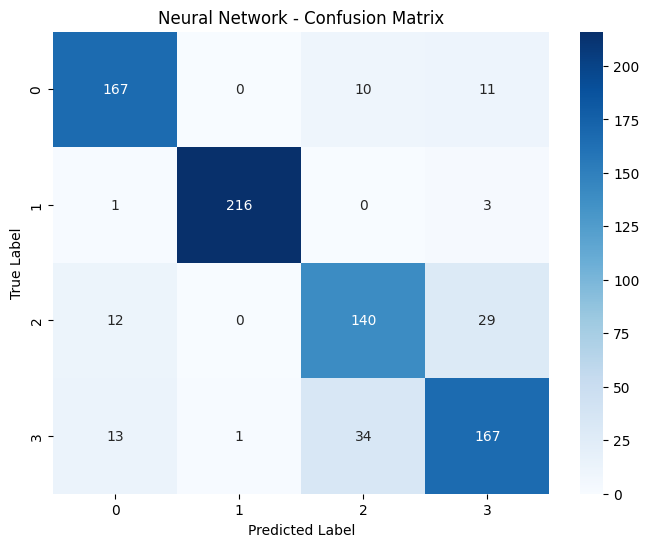

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for the Neural Network model
cm = confusion_matrix(y_test_int, models["Neural Network"].predict(X_test_features))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_int),
            yticklabels=np.unique(y_test_int))

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Neural Network - Confusion Matrix')
plt.show()


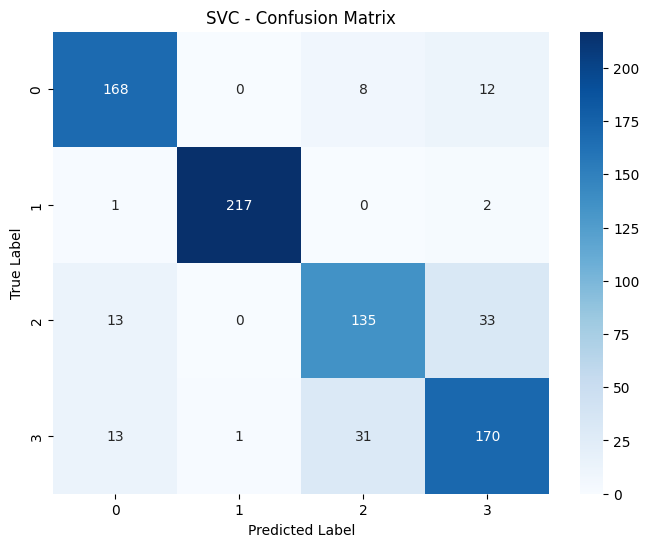

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for the SVC model
cm = confusion_matrix(y_test_int, models["SVC"].predict(X_test_features))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_int),
            yticklabels=np.unique(y_test_int))

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVC - Confusion Matrix')
plt.show()


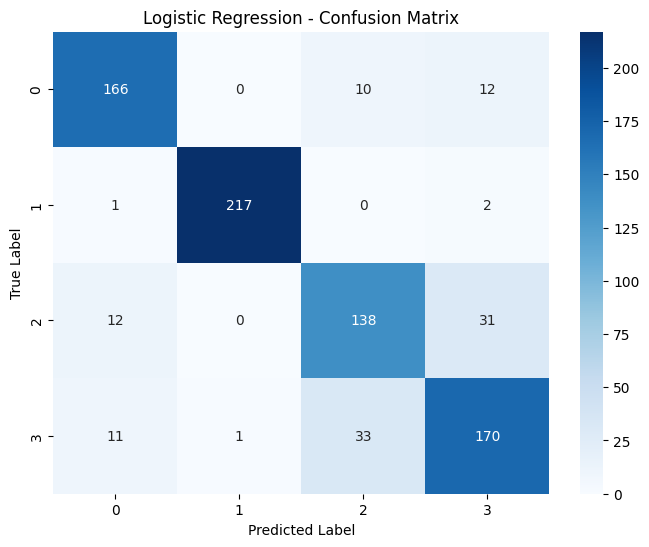

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for the Logistic Regression model
cm = confusion_matrix(y_test_int, models["Logistic Regression"].predict(X_test_features))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_int),
            yticklabels=np.unique(y_test_int))

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()


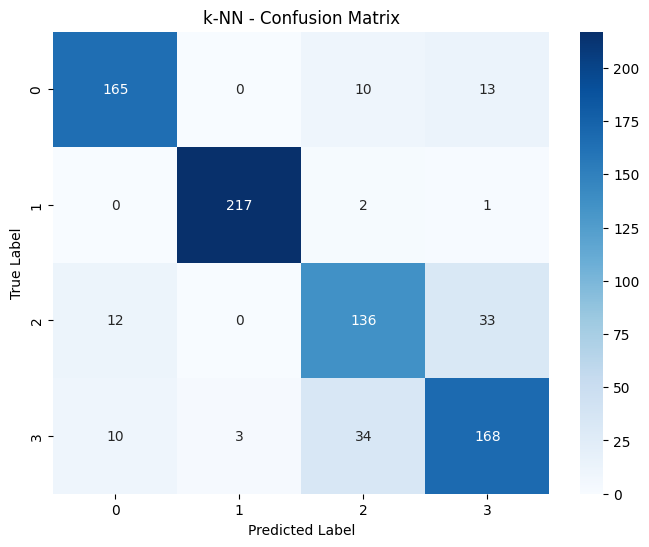

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for the k-NN model
cm = confusion_matrix(y_test_int, models["k-NN"].predict(X_test_features))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_int),
            yticklabels=np.unique(y_test_int))

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('k-NN - Confusion Matrix')
plt.show()


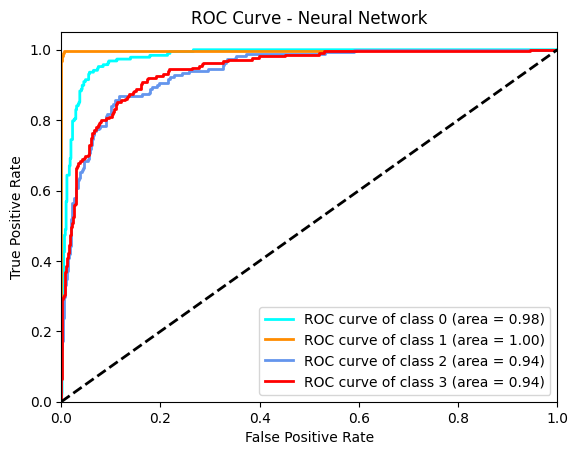

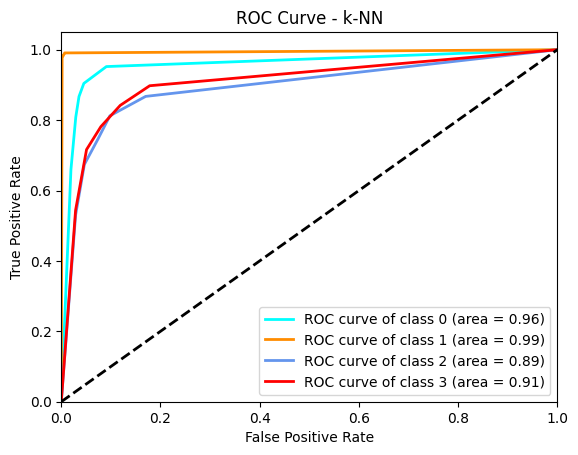

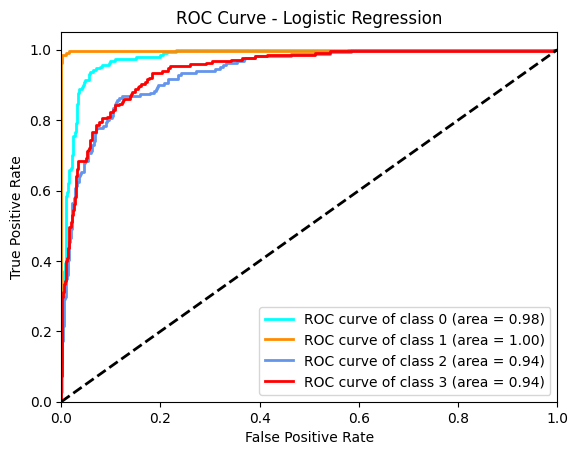

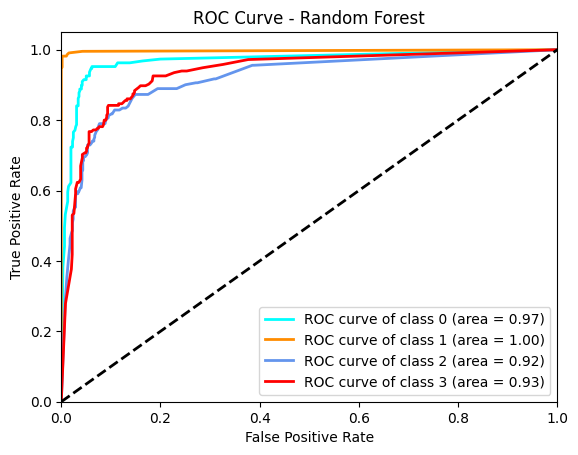

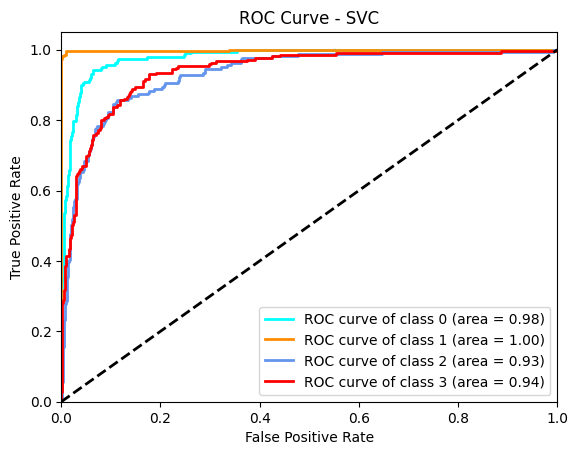

In [41]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

# Number of classes in the classification problem
n_classes = y_test_cat.shape[1]

# Convert integer labels to one-hot encoded (binarized) format
y_test_bin = label_binarize(y_test_int, classes=range(n_classes))

# Function to plot the ROC curve for each class
def plot_roc(y_true_bin, y_score, n_classes, model_name):
    fpr = dict()  # False Positive Rate for each class
    tpr = dict()  # True Positive Rate for each class
    roc_auc = dict()  # Area Under Curve for each class
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])  # Colors for each curve

    # Calculate FPR, TPR, and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot the ROC curves
    plt.figure()
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random classifier
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Example usage: plot ROC for all models that support predict_proba
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_features)
        plot_roc(y_test_bin, y_score, n_classes, name)
